# Flower Classification — Iris Dataset

**Colab-ready notebook**

This notebook is converted from `flower_classification_colab.py`. It performs EDA, trains Logistic Regression and Decision Tree models, compares them, plots confusion matrices and saves the best model. Run cells in order on Google Colab.

In [10]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import itertools

# Additional setup
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)
print('Artifacts directory created: ./artifacts')

Artifacts directory created: ./artifacts


## Overview

This notebook follows the same flow as the original script:

1. Load Iris dataset and inspect
2. Pairwise visualization
3. Train Logistic Regression and Decision Tree
4. Evaluate and compare
5. Plot confusion matrices and decision tree
6. Save best model and artifacts

Run each cell in order. Output files will be saved to `./artifacts/`.

Flower Classification - Project 1 (Iris)
Colab-ready script.
Features:
- Load Iris dataset
- EDA & pairwise visualization
- Train LogisticRegression and DecisionTreeClassifier
- Compare accuracy, plot confusion matrices
- Interpret misclassifications
- Save best model pipeline (scaler+model) to artifacts/
- CLI-like predict function for new samples


# If running in Colab, uncomment to install missing libs (usually not needed)
# !pip install scikit-learn matplotlib pandas joblib

import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ---------------------------
# Helper: ensure artifacts dir
# ---------------------------
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# ---------------------------
# 1) Load dataset & EDA
# ---------------------------

In [2]:
def load_and_inspect():
    iris = load_iris(as_frame=True)
    X = iris.data.copy()
    y = iris.target.copy()
    feature_names = iris.feature_names
    target_names = iris.target_names

    print("Dataset shape:", X.shape)
    display_df = pd.concat([X, pd.Series(y, name="species")], axis=1)
    print("\\nFirst 5 rows:")
    print(display_df.head())
    print("\\nDescription:")
    print(X.describe().T)
    print("\\nClass distribution:")
    print(y.value_counts().rename(index=lambda i: target_names[i]))

    return X, y, feature_names, target_names

# ---------------------------
# 2) Pairwise visualization
# ---------------------------

In [3]:
def plot_pairwise(X, y, target_names, save_path=None):
    # Avoid seaborn dependency — simple pair scatter matrix with colors
    import itertools
    cols = X.columns.tolist()
    n = len(cols)
    fig, axes = plt.subplots(n, n, figsize=(12, 12))
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    for i, j in itertools.product(range(n), range(n)):
        ax = axes[i, j]
        if i == j:
            ax.hist(X[cols[i]], bins=15, color="#888888", alpha=0.6)
            ax.set_xlabel(cols[i])
        else:
            for class_idx, cname in enumerate(target_names):
                mask = (y == class_idx)
                ax.scatter(X.loc[mask, cols[j]], X.loc[mask, cols[i]],
                           s=15, alpha=0.7, color=colors[class_idx], label=cname if (i==0 and j==1 and class_idx==0) else "")
        if i == n-1:
            ax.set_xlabel(cols[j])
        if j == 0:
            ax.set_ylabel(cols[i])
    # single legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=target_names[k],
                          markerfacecolor=colors[k], markersize=8) for k in range(len(target_names))]
    fig.legend(handles=handles, loc='upper right')
    plt.suptitle("Pairwise feature scatter / hist (Iris dataset)", y=0.92)
    plt.tight_layout(rect=[0,0,0.95,0.95])
    if save_path:
        fig.savefig(save_path, dpi=200)
        print(f"Saved pairwise plot to {save_path}")
    plt.show()

# ---------------------------
# 3) Train models & evaluate
# ---------------------------

In [4]:
def train_and_compare(X_train, X_test, y_train, y_test):
    results = {}

    # Logistic Regression pipeline (scaler + classifier)
    pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200, random_state=42))
    pipe_lr.fit(X_train, y_train)
    y_pred_lr = pipe_lr.predict(X_test)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    results['LogisticRegression'] = {
        'pipeline': pipe_lr,
        'y_pred': y_pred_lr,
        'accuracy': acc_lr,
        'report': classification_report(y_test, y_pred_lr, output_dict=True),
        'confusion': confusion_matrix(y_test, y_pred_lr)
    }
    print(f"Logistic Regression accuracy: {acc_lr:.4f}")

    # Decision Tree pipeline (no scaler needed, but keep pipeline for consistency)
    pipe_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=42))
    pipe_dt.fit(X_train, y_train)
    y_pred_dt = pipe_dt.predict(X_test)
    acc_dt = accuracy_score(y_test, y_pred_dt)
    results['DecisionTree'] = {
        'pipeline': pipe_dt,
        'y_pred': y_pred_dt,
        'accuracy': acc_dt,
        'report': classification_report(y_test, y_pred_dt, output_dict=True),
        'confusion': confusion_matrix(y_test, y_pred_dt)
    }
    print(f"Decision Tree accuracy:     {acc_dt:.4f}")

    return results

# ---------------------------
# 4) Plot confusion matrices & tree
# ---------------------------

In [5]:
def plot_confusion_and_tree(results, y_test, target_names, save_prefix="artifacts/"):
    for name, res in results.items():
        cm = res['confusion']
        fig, ax = plt.subplots(figsize=(5,4))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp.plot(ax=ax)
        plt.title(f"{name} - Confusion Matrix")
        plt.tight_layout()
        out = os.path.join(save_prefix, f"confusion_{name}.png")
        fig.savefig(out, dpi=200)
        print(f"Saved confusion matrix: {out}")
        plt.show()

    # If DecisionTree is present, plot the tree structure (visual)
    if 'DecisionTree' in results:
        dt_pipeline = results['DecisionTree']['pipeline']
        # extract trained DecisionTreeClassifier from pipeline
        # pipeline steps: StandardScaler -> DecisionTreeClassifier
        tree_clf = None
        for step in dt_pipeline.steps:
            if isinstance(step[1], DecisionTreeClassifier):
                tree_clf = step[1]
        if tree_clf is None:
            print("DecisionTreeClassifier not found in pipeline steps.")
            return
        fig, ax = plt.subplots(figsize=(12,6))
        plot_tree(tree_clf, feature_names=X.columns, class_names=target_names, filled=True, rounded=True, ax=ax)
        out_tree = os.path.join(save_prefix, "decision_tree_plot.png")
        plt.title("Decision Tree Structure")
        fig.savefig(out_tree, dpi=200)
        print(f"Saved decision tree plot: {out_tree}")
        plt.show()

# ---------------------------
# 5) Interpret misclassifications
# ---------------------------

In [6]:
def analyze_misclassifications(X_test, y_test, y_pred, target_names):
    df = X_test.copy().reset_index(drop=True)
    df['actual'] = y_test.reset_index(drop=True)
    df['predicted'] = y_pred
    mis = df[df['actual'] != df['predicted']]
    print(f"Misclassifications ({len(mis)} rows):")
    if len(mis) == 0:
        print("No misclassifications on the test set.")
    else:
        print(mis)
    mis.to_csv(os.path.join(ARTIFACT_DIR, "misclassifications.csv"), index=False)
    print(f"Saved misclassifications to {os.path.join(ARTIFACT_DIR, 'misclassifications.csv')}")
    return mis

# ---------------------------
# 6) Save best model
# ---------------------------

In [11]:
def save_best_model(results, prefix=ARTIFACT_DIR):
    # pick best by accuracy
    best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_pipe = results[best_name]['pipeline']
    out_path = os.path.join(prefix, f"best_model_{best_name}.pkl")
    joblib.dump(best_pipe, out_path)
    print(f"Saved best model pipeline ({best_name}) to {out_path}")
    # Save accuracies and reports
    summary = []
    for name, res in results.items():
        summary.append({
            "model": name,
            "accuracy": res['accuracy']
        })
        # save classification report per model
        pd.DataFrame(res['report']).transpose().to_csv(os.path.join(prefix, f"classification_report_{name}.csv"))
    pd.DataFrame(summary).to_csv(os.path.join(prefix, "model_comparison_summary.csv"), index=False)
    print(f"Saved model comparison summary to {os.path.join(prefix, 'model_comparison_summary.csv')}")
    return best_name, out_path

# ---------------------------
# 7) CLI-like prediction helper
# ---------------------------

In [12]:
def predict_new_sample(model_path=None, sample_dict=None):
    """
    If sample_dict provided, predict from it; else prompts user for input (works in terminal).
    sample_dict keys should match feature names: sepal length, sepal width, petal length, petal width.
    """
    if model_path is None:
        # try to pick the best model in artifacts
        candidates = [f for f in os.listdir(ARTIFACT_DIR) if f.startswith("best_model_") and f.endswith(".pkl")]
        if not candidates:
            raise FileNotFoundError("No best_model_*.pkl found in artifacts/. Run training first.")
        model_path = os.path.join(ARTIFACT_DIR, candidates[0])
    pipe = joblib.load(model_path)
    feat_names = X.columns.tolist()

    if sample_dict is None:
        print("Enter feature values for prediction:")
        sample_vals = []
        for fn in feat_names:
            v = input(f"{fn} : ")
            sample_vals.append(float(v))
        sample = np.array(sample_vals).reshape(1, -1)
    else:
        # ensure order
        sample = np.array([sample_dict[fn] for fn in feat_names]).reshape(1, -1)

    pred = pipe.predict(sample)
    pred_proba = None
    try:
        pred_proba = pipe.predict_proba(sample)
    except Exception:
        pass

    return pred[0], pred_proba

# ---------------------------
# Main execution (wrap into function for importability)
# ---------------------------

In [13]:
def run_full_pipeline():
    global X  # used for tree plotting function that needs feature names
    X, y, feature_names, target_names = load_and_inspect()

    # Pairwise plot (saves image)
    plot_pairwise(X, y, target_names, save_path=os.path.join(ARTIFACT_DIR, "pairwise_plot.png"))

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    print("\\nTrain/Test split done. Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

    # Train and compare
    results = train_and_compare(X_train, X_test, y_train, y_test)

    # Save confusion matrices and plot tree
    plot_confusion_and_tree(results, y_test, target_names, save_prefix=ARTIFACT_DIR)

    # Analyze misclassifications for the best model (choose model with highest accuracy)
    best = max(results.keys(), key=lambda k: results[k]['accuracy'])
    print(f"\\nBest model by accuracy: {best}")
    mis = analyze_misclassifications(X_test, y_test, results[best]['y_pred'], target_names)

    # Save best model and summary
    best_name, best_path = save_best_model(results, prefix=ARTIFACT_DIR)

    print("\\nAll artifacts saved to:", ARTIFACT_DIR)
    print("To predict on new sample programmatically, call predict_new_sample(model_path='<path>', sample_dict={...})")
    print("Example sample_dict keys:", X.columns.tolist())

    # also return objects for interactive use
    return {
        "X": X, "y": y, "results": results, "best_model_name": best_name, "best_model_path": best_path
    }

# Run when executed as script

## Run pipeline (script entry point)

This cell runs the full pipeline. It will execute the functions defined above and save artifacts to `./artifacts/`.

Starting Flower Classification pipeline (Iris)...
Dataset shape: (150, 4)
\nFirst 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0        0  
1        0  
2        0  
3        0  
4        0  
\nDescription:
                   count      mean       std  min  25%   50%  75%  max
sepal length (cm)  150.0  5.843333  0.828066  4.3  5.1  5.80  6.4  7.9
sepal width (cm)   150.0  3.057333  0.435866  2.0  2.8  3.00  3.3  4.4
petal length (cm)  150.0  3.758000  1.765298  1.0  1.6  4.35  5.1  6.9
petal width (cm)   150.0  1.199333  0.762238  0.1  0.3  1.

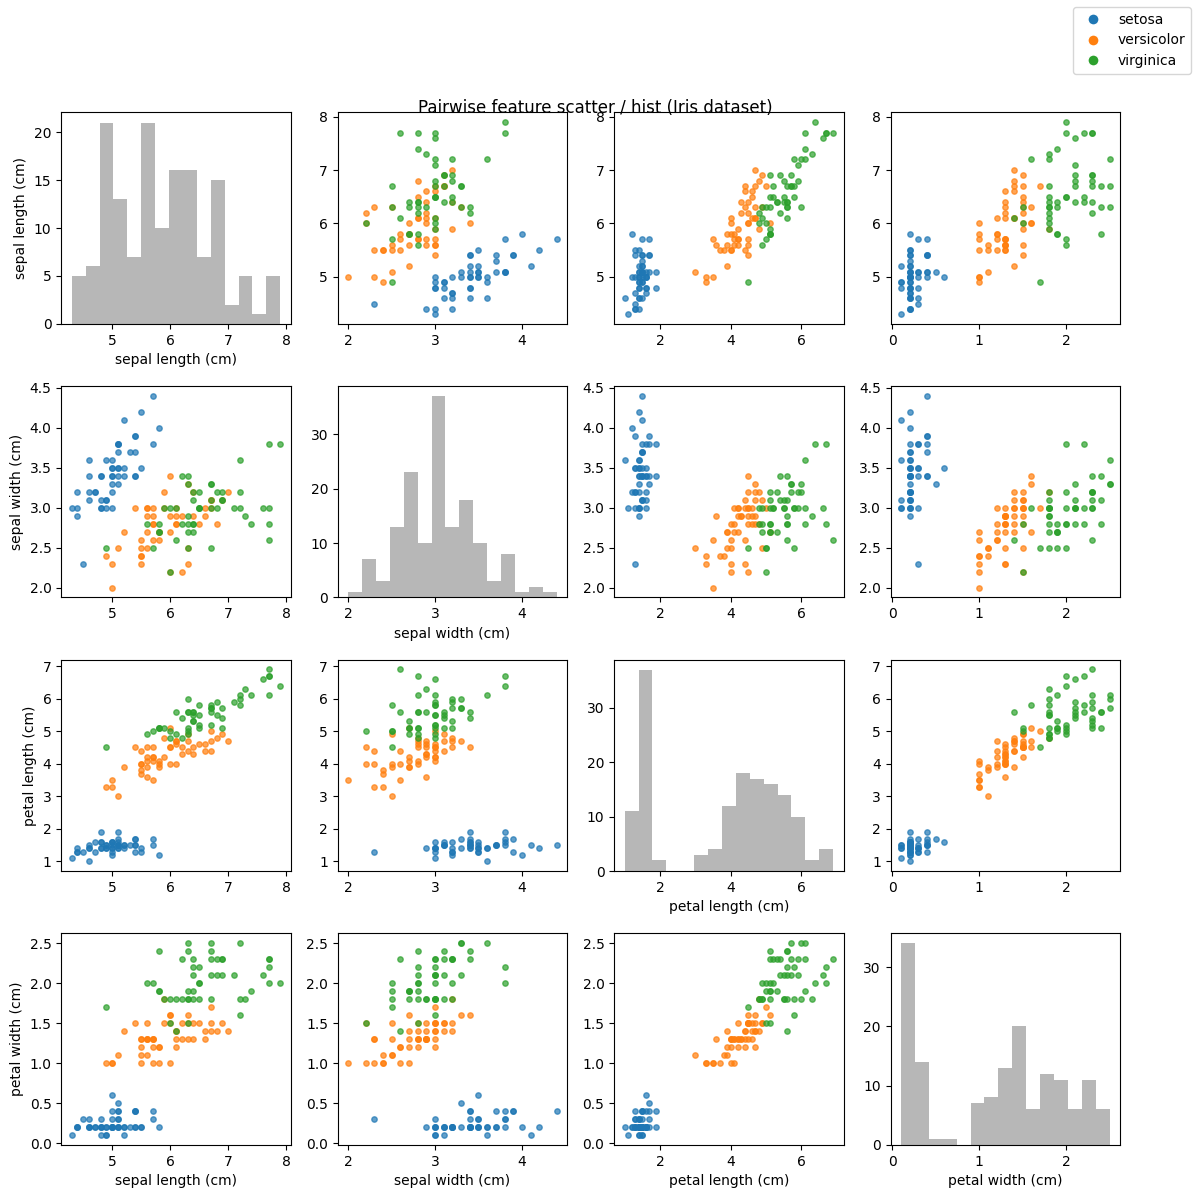

\nTrain/Test split done. Train size: 120 Test size: 30
Logistic Regression accuracy: 0.9333
Decision Tree accuracy:     0.9333
Saved confusion matrix: artifacts/confusion_LogisticRegression.png


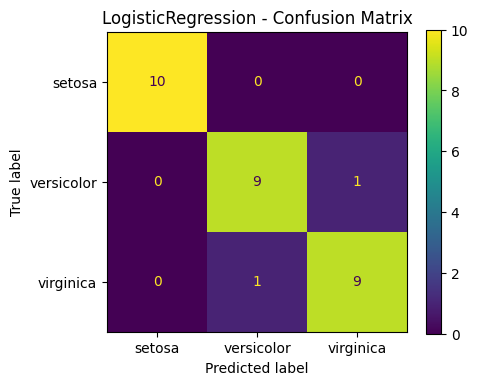

Saved confusion matrix: artifacts/confusion_DecisionTree.png


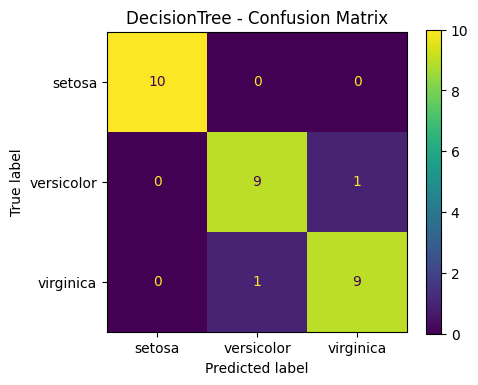

Saved decision tree plot: artifacts/decision_tree_plot.png


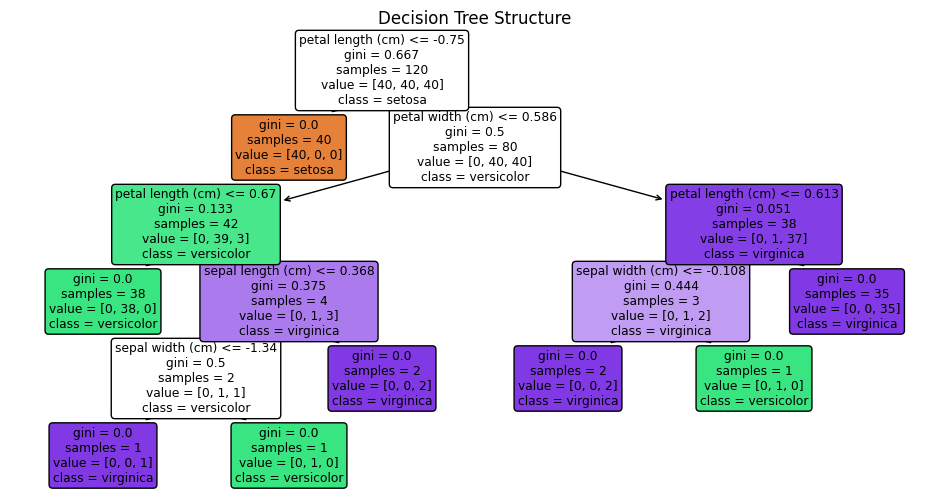

\nBest model by accuracy: LogisticRegression
Misclassifications (2 rows):
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
23                6.1               2.6                5.6               1.4   
25                6.7               3.0                5.0               1.7   

    actual  predicted  
23       2          1  
25       1          2  
Saved misclassifications to artifacts/misclassifications.csv
Saved best model pipeline (LogisticRegression) to artifacts/best_model_LogisticRegression.pkl
Saved model comparison summary to artifacts/model_comparison_summary.csv
\nAll artifacts saved to: artifacts
To predict on new sample programmatically, call predict_new_sample(model_path='<path>', sample_dict={...})
Example sample_dict keys: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
\nExample prediction on mean-value sample:
Sample features: {'sepal length (cm)': 5.843, 'sepal width (cm)': 3.057, 'petal length (cm

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [14]:
if __name__ == "__main__":
    print("Starting Flower Classification pipeline (Iris)...")
    outputs = run_full_pipeline()

    # Example of programmatic prediction for demonstration (take mean values as sample)
    sample_example = dict(zip(outputs['X'].columns, outputs['X'].mean().round(3).tolist()))
    pred_label, pred_proba = predict_new_sample(model_path=outputs['best_model_path'], sample_dict=sample_example)
    print("\\nExample prediction on mean-value sample:")
    print("Sample features:", sample_example)
    print("Predicted class index:", pred_label)
    if pred_proba is not None:
        print("Predicted class probabilities:", np.round(pred_proba, 3))

    # Save a short summary CSV
    summary_df = pd.DataFrame([{
        "best_model": outputs['best_model_name'],
        "best_model_path": outputs['best_model_path']
    }])
    summary_df.to_csv(os.path.join(ARTIFACT_DIR, "run_summary.csv"), index=False)
    print("Done.")

## Notes

- To run: Upload this notebook to Google Colab and run all cells.
- Artifacts (saved models, confusion matrices, and CSVs) will appear in `./artifacts/`.
- If you want the original script also available, it is at `/mnt/data/flower_classification_colab.py` in this environment.